In [156]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import easyocr
import imutils
import random

# Number Plate Detection and Recognition

This notebook demonstrates a pipeline for detecting and recognizing vehicle number plates using computer vision techniques:

1. Pre-processing: Convert to grayscale, reduce noise, and enhance contrast
2. Edge detection: Identify potential plate boundaries
3. Contour detection: Find the most likely rectangular regions
4. Filtering: Use geometric properties to isolate the plate
5. OCR: Extract text from the detected plate region

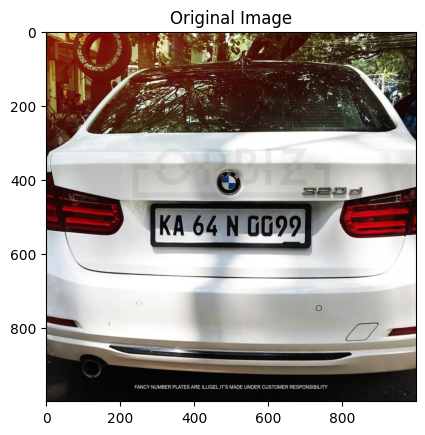

Text(0.5, 1.0, 'Processed Image')

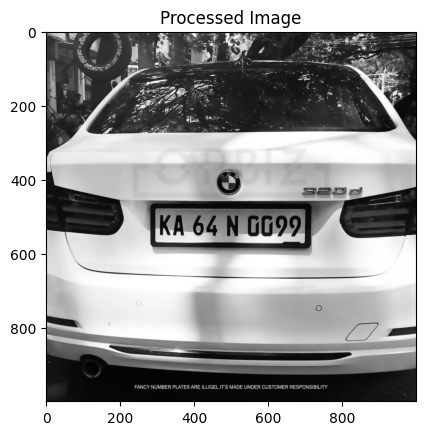

In [157]:
img = cv2.imread(
    "/Users/adityaparikh/Developer/Personal/car-damage-detectron/dataset1/number plates/9.png")  # read image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert image to gray
bfilter = cv2.bilateralFilter(gray, 11, 17, 17)  # Noise reduction
plt.imshow(cv2.cvtColor(bfilter, cv2.COLOR_BGR2RGB))  # show processed image
plt.title('Processed Image')

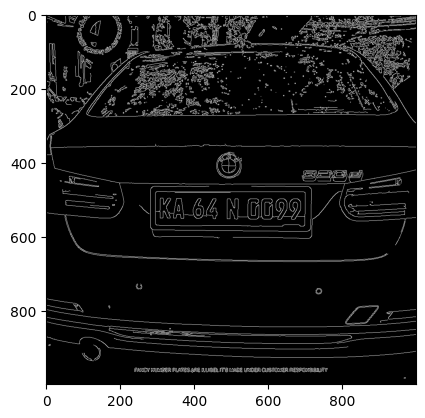

In [158]:
edged = cv2.Canny(bfilter, 30, 200)  # Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

In [159]:
keypoints = cv2.findContours(
    edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
contours = imutils.grab_contours(keypoints)  # Grab contours
contours = sorted(contours, key=cv2.contourArea, reverse=True)[
    :10]  # Sort contours

In [160]:
# Loop over our contours to find the best possible approximate contour of 10 contours
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

print("Location: ", location)

Location:  [[[295 484]]

 [[298 570]]

 [[699 570]]

 [[696 480]]]


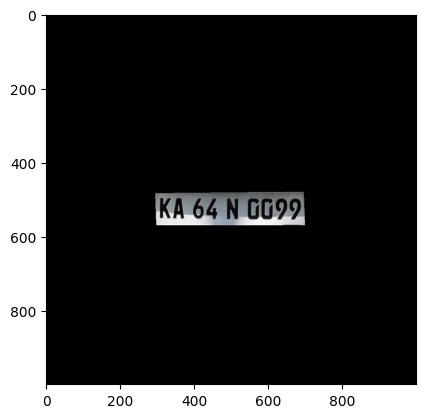

In [161]:
# create blank image with same dimensions as the original image
mask = np.zeros(gray.shape, np.uint8)
# Draw contours on the mask image
new_image = cv2.drawContours(mask, [location], 0, 255, -1)
# Take bitwise AND between the original image and mask image
new_image = cv2.bitwise_and(img, img, mask=mask)

plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))  # show the final image

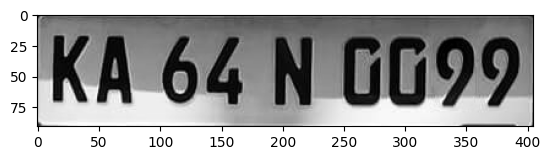

In [162]:
# Find the co-ordinates of the four corners of the document
(x, y) = np.where(mask == 255)
(x1, y1) = (np.min(x), np.min(y))  # Find the top left corner
(x2, y2) = (np.max(x), np.max(y))  # Find the bottom right corner
cropped_image = gray[x1:x2+1, y1:y2+1]  # Crop the image using the co-ordinates

# show the cropped image
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

In [163]:
# create an easyocr reader object with english as the language
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)  # read text from the cropped image
result

[([[np.int32(3), np.int32(5)],
   [405, np.int32(5)],
   [405, np.int32(90)],
   [np.int32(3), np.int32(90)]],
  'KA 64 N 0099',
  np.float64(0.4863551744524429))]

KA 64 N 0099


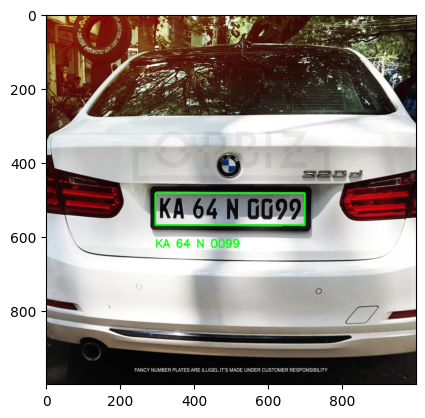

In [ ]:
text = result[0][-2]  # Extract the text from the result
font = cv2.FONT_HERSHEY_SIMPLEX  # Font style
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(
    0, 255, 0), thickness=2, lineType=cv2.LINE_AA)  # put the text on the image
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(
    approx[2][0]), (0, 255, 0), 3)  # Draw a rectangle around the text

# show the final image with text
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
print(text)

In [ ]:
def detect_license_plate(image_path):
    """Process a single image to detect and extract license plate text.
    
    Args:
        image_path: Path to the input image
        
    Returns:
        dict: Dictionary containing detection results
    """
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        return {"success": False, "error": "Could not read image"}
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply histogram equalization
    equ = cv2.equalizeHist(gray)
    
    # Noise reduction
    bfilter = cv2.bilateralFilter(equ, 11, 17, 17)
    
    # Edge detection
    edged = cv2.Canny(bfilter, 30, 200)
    kernel = np.ones((3, 3), np.uint8)
    edged = cv2.dilate(edged, kernel, iterations=1)
    
    # Find contours
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:20]
    
    # Find potential plates by filtering contours
    potential_plates = []
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
        if 1.5 <= aspect_ratio <= 7.0 and cv2.contourArea(contour) > 1000:
            approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
            if len(approx) == 4:
                potential_plates.append(approx)
    
    # Fall back to simple method if needed
    if not potential_plates:
        for contour in contours[:10]:
            approx = cv2.approxPolyDP(contour, 10, True)
            if len(approx) == 4:
                potential_plates = [approx]
                break
    
    # If no plate found, return failure
    if not potential_plates:
        return {"success": False, "error": "No license plate detected"}
    
    # Use the first potential plate
    location = potential_plates[0]
    
    # Create mask and extract plate region
    mask = np.zeros(gray.shape, np.uint8)
    cv2.drawContours(mask, [location], 0, 255, -1)
    (x, y) = np.where(mask == 255)
    if len(x) == 0 or len(y) == 0:
        return {"success": False, "error": "Invalid mask region"}
    
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    cropped_image = gray[x1:x2+1, y1:y2+1]
    
    # Enhance the cropped image
    if cropped_image.shape[1] < 300:  # If width is small
        scale_factor = 300 / cropped_image.shape[1]
        width = int(cropped_image.shape[1] * scale_factor)
        height = int(cropped_image.shape[0] * scale_factor)
        resized = cv2.resize(cropped_image, (width, height), interpolation=cv2.INTER_CUBIC)
    else:
        resized = cropped_image.copy()
    
    equalized = cv2.equalizeHist(resized)
    thresh = cv2.adaptiveThreshold(equalized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY_INV, 11, 2)
    
    kernel = np.ones((2, 2), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)
    final_img = cv2.bitwise_not(morph)
    
    # Perform OCR
    reader = easyocr.Reader(['en'])
    result = reader.readtext(final_img)
    
    if not result:
        # Try original cropped image if enhanced version fails
        result = reader.readtext(cropped_image)
    
    if result:
        text = result[0][-2]
        confidence = result[0][-1]
        
        # Draw result on image
        result_img = img.copy()
        rect = cv2.minAreaRect(location)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(result_img, [box], 0, (0, 255, 0), 3)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        text_x = np.min(box[:, 0])
        text_y = np.max(box[:, 1]) + 30
        cv2.putText(result_img, text=text, org=(text_x, text_y), fontFace=font, 
                    fontScale=1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
        
        return {
            "success": True, 
            "text": text, 
            "confidence": confidence,
            "result_image": result_img,
            "plate_image": final_img
        }
    else:
        return {"success": False, "error": "Could not read text from plate"}

# Example of how to use the function:
# result = detect_license_plate("/Users/adityaparikh/Developer/Personal/car-damage-detectron/dataset1/number plates/1.png")
# if result["success"]:
#     plt.figure(figsize=(12, 10))
#     plt.imshow(cv2.cvtColor(result["result_image"], cv2.COLOR_BGR2RGB))
#     plt.title(f'License Plate: {result["text"]} (Confidence: {result["confidence"]:.2f})')
#     plt.show()

In [ ]:
# Process multiple license plate images
import glob
import os

# Get all license plate images from the dataset
plate_images = glob.glob("/Users/adityaparikh/Developer/Personal/car-damage-detectron/dataset1/number plates/*.png")
plate_images += glob.glob("/Users/adityaparikh/Developer/Personal/car-damage-detectron/dataset1/number plates/*.jpg")
plate_images += glob.glob("/Users/adityaparikh/Developer/Personal/car-damage-detectron/dataset1/number plates/*.jpeg")
plate_images += glob.glob("/Users/adityaparikh/Developer/Personal/car-damage-detectron/dataset1/number plates/*.webp")

print(f"Found {len(plate_images)} license plate images")

# Process a few images (change the range to process more)
results = []
for i, img_path in enumerate(plate_images[:3]):  # Process first 3 images
    print(f"Processing image {i+1}/{len(plate_images[:3])}: {os.path.basename(img_path)}")
    result = detect_license_plate(img_path)
    result['file'] = os.path.basename(img_path)
    results.append(result)
    
    # Display result if successful
    if result["success"]:
        plt.figure(figsize=(14, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(result["result_image"], cv2.COLOR_BGR2RGB))
        plt.title(f'Detection: {result["text"]} (Conf: {result["confidence"]:.2f})')
        
        plt.subplot(1, 2, 2)
        plt.imshow(result["plate_image"], cmap='gray')
        plt.title('Processed Plate Region')
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"  Failed: {result['error']}")

# Print summary
print("\nSummary:")
print("-" * 60)
print(f"{'Filename':<20} {'Text':<15} {'Confidence':<10} {'Status':<10}")
print("-" * 60)

for result in results:
    if result["success"]:
        print(f"{result['file']:<20} {result['text']:<15} {result['confidence']:.4f} {'Success':<10}")
    else:
        print(f"{result['file']:<20} {'N/A':<15} {'N/A':<10} {'Failed':<10}")
        
print("-" * 60)
success_rate = sum(1 for r in results if r["success"]) / len(results) * 100
print(f"Success rate: {success_rate:.1f}%")

# Recommendations for Further Improvements

1. **Deep Learning Approaches**:
   - Use YOLO or other object detection models specifically trained for license plate detection
   - Train a custom model on your specific dataset of license plates

2. **Additional Pre-processing Techniques**:
   - Try different color spaces (HSV, LAB) for better segmentation
   - Implement perspective correction to handle skewed plates
   - Use more advanced denoising techniques like non-local means denoising

3. **Post-processing for OCR**:
   - Apply character segmentation before OCR
   - Implement a validation step to verify that the OCR output matches license plate patterns
   - Use a specialized OCR model trained specifically on license plate fonts

4. **Multiple Detection Methods**:
   - Implement a fallback pipeline that tries different detection methods
   - Ensemble multiple detection approaches and use voting

5. **Performance Optimization**:
   - Parallelize processing for batch operations
   - Implement GPU acceleration where available